# Model: Anomaly Detection using prediction-based with scheduled online learning

- The model uses the prediction-based anomaly detection technique, which is based on the idea that if a model can predict the next value in a time series, it can also detect anomalies by measuring the difference between the predicted and actual values.

- The model uses **LSTM**; it trains on 24 months and then at each new month (stream) it checks for anomalies and updates the model with new data every 6 months.

- The **data normalization** is done using a log transformation, subtracting the mean, and dividing by the standard deviation.

- This model uses **all-time hcpi_m for one country**.

- Version: 0.1.0 : proof of concept

- **Notes**

    - The anomaly detection depends on the threshold which was empirically set to 2.5 based on my observations.

    - It works only for one country at a time.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Read the data

In [2]:
hcpi = pd.read_parquet("data/hcpi_m.parquet")

print(hcpi.shape)
hcpi.sample(3)

(663, 185)


,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ATG,AUT,AZE,...,VCT,VEN,VGB,VNM,WSM,XKX,YEM,ZAF,ZMB,ZWE
2011-08-01,96.844,86.0933,22.369316,84.682627,89.200565,NaN,103.95914,91.278346,93.53116,106.9,...,105.0,246.9,NaN,74.661952,96.333639,95.285002,142.942049,81.12144,116.6,1.97642
1978-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.31095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00751,NaN,NaN
1997-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.83054,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.78532,NaN,NaN


# Identifying anomalies per country

select a random country

In [ ]:
country = hcpi.columns[np.random.randint(0, hcpi.shape[1])] #"PRT"

with open("data/countries.json", "r") as f:
    countries = json.load(f)
print(f"Country: {countries[country]}")
country_name = countries[country]

port_ts = hcpi.loc[:, country]
port_ts = port_ts.dropna()
print(f"No missing values? {port_ts.isna().sum() == 0}")

port_ts

Country: Portugal
No missing values? True


1970-01-01      1.702706
1970-02-01      1.680877
1970-03-01      1.716598
1970-04-01      1.706675
1970-05-01      1.687823
                 ...    
2024-11-01    122.043000
2024-12-01    122.173000
2025-01-01    121.622000
2025-02-01    121.489000
2025-03-01    123.217000
Name: PRT, Length: 663, dtype: float64

define the model and some functions

In [4]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, seq_len=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.seq_len = seq_len

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.linear(out)
        return out.squeeze()
    

def make_supervised(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

def normalize(series, mean=None, std=None):
    series = np.log1p(series)
    if mean is None:
        mean = np.mean(series)
        std = np.std(series)
    return (series - mean) / std, mean, std

def denormalize(norm_series, mean, std):
    return np.expm1(norm_series * std + mean)

split the data into train and future stream

In [5]:
seq_len = 12
initial_months = 24  # 12 context + 12 train
retrain_every = 6    # retrain every 6 months

series = port_ts.values.astype(np.float32)
dates = port_ts.index.to_list()

train_series = series[:initial_months]
stream_series = series[initial_months:]
stream_dates = dates[initial_months:]

do the initial training

In [6]:
# initial train, using the initial_months and the normalized() series
train_norm, mean, std = normalize(train_series)
X_train, y_train = make_supervised(train_norm, seq_len)

X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

model = LSTMPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# define the threshold for anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_train_tensor)
    residuals = torch.abs(preds - y_train_tensor).numpy()
    threshold = max(np.percentile(residuals, 95), 2.5) #np.std(residuals) * 6

stream the data

- stream

- check if $t$ is an anomaly

- update the model if $t$ is the 6th month

In [7]:
anomaly_dates, anomaly_values = [], []

future_train_data = train_series

month_counter = 0

# start streaming the new data
for t in range(seq_len, len(stream_series)):

    # get the last seq_len months of data
    window = stream_series[t-seq_len:t]
    x = normalize(window, mean, std)[0]
    x_tensor = torch.tensor(x[np.newaxis, :, np.newaxis], dtype=torch.float32)

    # predict the next value (the current month)
    with torch.no_grad():
        pred = model(x_tensor).item()
        pred_denorm = denormalize(pred, mean, std)

    # get the true value
    date_t = stream_dates[t]
    true_val = stream_series[t]
    true_val_norm = normalize(true_val, mean, std)[0]

    # check for anomalies
    err = abs(pred - true_val_norm)
    if err > threshold:
        print(f"{date_t.strftime('%Y-%m')}  anomaly (error={err:.4f})")
        anomaly_dates.append(date_t)
        anomaly_values.append(true_val)

    future_train_data = np.append(future_train_data, true_val)
    month_counter += 1
    # retrain the model if should
    if month_counter % retrain_every == 0:
        # get the last seq_len months of data
        train_data = future_train_data[-(int(seq_len*1.5)):]
        train_data_norm, mean, std = normalize(train_data)

        # prepare the data for training
        X_train, y_train = make_supervised(train_data_norm, seq_len)
        X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

        # retrain the model
        model = LSTMPredictor()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(X_train_tensor)
            loss = criterion(out, y_train_tensor)
            loss.backward()
            optimizer.step()

        # define the new threshold
        model.eval()
        with torch.no_grad():
            preds = model(X_train_tensor)
            residuals = torch.abs(preds - y_train_tensor).numpy()
            threshold = max(np.percentile(residuals, 95), 2.5) #np.std(residuals) * 6

1976-10  anomaly (error=2.8599)
1976-11  anomaly (error=3.0131)
1976-12  anomaly (error=3.6053)
1977-04  anomaly (error=2.5301)
1977-05  anomaly (error=2.6291)
1977-06  anomaly (error=2.6384)
1979-05  anomaly (error=2.5941)
1979-06  anomaly (error=2.5999)
1981-06  anomaly (error=2.5867)
1981-10  anomaly (error=2.5882)
1981-11  anomaly (error=2.7494)
1981-12  anomaly (error=3.1197)
1983-06  anomaly (error=2.6370)
1983-12  anomaly (error=2.6547)
1988-11  anomaly (error=2.7468)
1988-12  anomaly (error=3.0369)
1998-05  anomaly (error=2.7875)
1998-06  anomaly (error=2.8994)
1998-11  anomaly (error=2.6751)
1998-12  anomaly (error=3.0216)
2000-06  anomaly (error=2.9725)
2000-11  anomaly (error=2.8481)
2000-12  anomaly (error=3.1713)
2001-06  anomaly (error=2.5910)
2005-12  anomaly (error=2.5253)
2006-04  anomaly (error=2.5624)
2006-05  anomaly (error=2.9021)
2006-06  anomaly (error=2.8437)
2008-06  anomaly (error=2.7289)
2010-06  anomaly (error=2.6403)
2010-10  anomaly (error=2.8255)
2010-11 

plot the anomalies

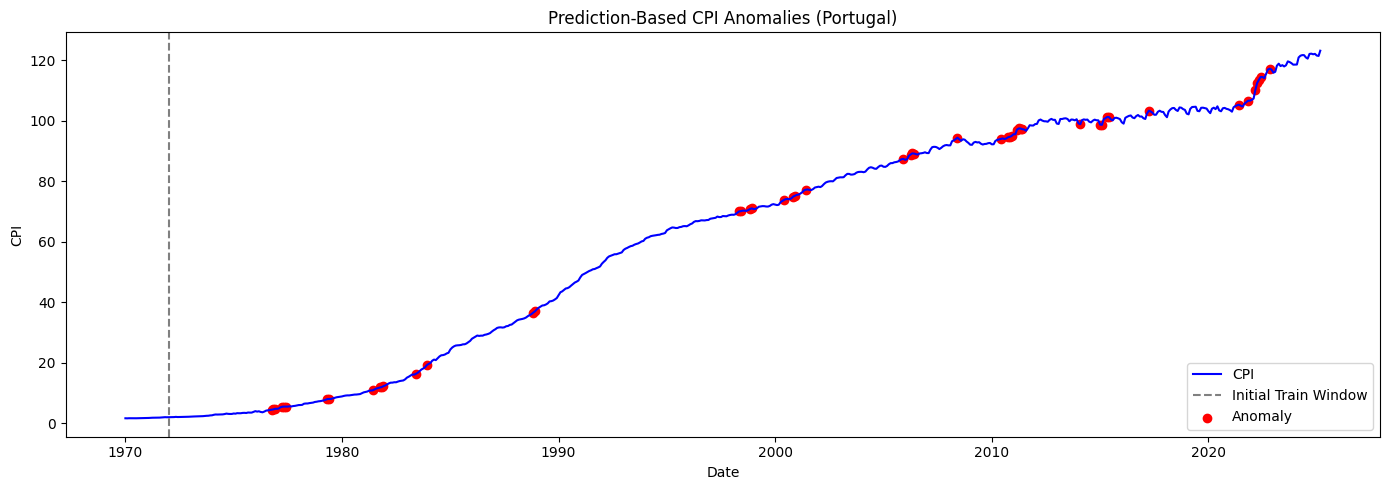

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(dates, series, label="CPI", color='blue')
plt.axvline(x=dates[initial_months], color='gray', linestyle='--', label='Initial Train Window')
plt.scatter(anomaly_dates, anomaly_values, color='red', label='Anomaly')

plt.title(f"Prediction-Based CPI Anomalies ({country_name})")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.yscale("log")
plt.tight_layout()
plt.show()